In [151]:
from copy import deepcopy
from PIL import Image, ImageDraw
from time import time

import math
import numpy as np
import random

In [152]:
class Individual:
    def __init__(self, parameters, father=None, mother=None):
        self.parse_parameters(parameters)
        self.dna = []

        if father is None or mother is None:
            # Create random individual
            
            for _ in range(self.dna_size):
                polygon = tuple([self._random_vertex() for _ in range(3)])
                self.dna.append((polygon, self._random_color()))
        else:
            # Crossover
            
            if not self.random_inheritance:
                # Get half of its genes from its parents
                half = self.dna_size // 2
                other = self.dna_size - half

                father_sample = deepcopy(random.sample(father.dna, k=half))
                mother_sample = deepcopy(random.sample(mother.dna, k=other))
            else:
                father_amount = int(self.dna_size * random.uniform(0.0, 1.0))
                other = self.dna_size - father_amount
                
                father_sample = deepcopy(random.sample(father.dna, k=father_amount))
                mother_sample = deepcopy(random.sample(mother.dna, k=other))
            
            self.dna = father_sample + mother_sample

        mutate = random.uniform(0.0, 1.0)
        if mutate < self.mutation_chance:
            # Mutation
            ratio = self.mutation_ratio
            for i, g in enumerate(self.dna):
                self.dna[i] = (
                    self._mutate_polygon(self.dna[i][0], ratio), 
                    self._mutate_color(self.dna[i][1], ratio)
                )

        self.draw()
        self.fit()
    
    def __lt__(self, other):
        return self.fitness < other.fitness
    
    def draw(self):
        '''Draws individual into a black canvas'''
        size = self.target.size

        self.canvas = Image.new(mode='RGB', size=size)
        self.draw_obj = ImageDraw.Draw(self.canvas, mode=self.mode)

        for gene in self.dna:
            self.draw_obj.polygon(gene[0], fill=gene[1])

    def fit(self):
        '''Fits individual against target image'''
        self.fitness = self.func(self.canvas, self.target)

    def parse_parameters(self, parameters):
        if 'DNA_SIZE' not in parameters:
            raise KeyError('DNA_SIZE not specified in parameters')
        self.dna_size = parameters['DNA_SIZE']

        if 'MUTATION_CHANCE' not in parameters or type(parameters['MUTATION_CHANCE']) not in [float, np.float64]:
            raise KeyError('MUTATION_CHANCE is invalid or missing. Specify float in the range [0.0, 1.0]')
        self.mutation_chance = parameters['MUTATION_CHANCE']
        
        if 'MUTATION_AMOUNT' not in parameters or type(parameters['MUTATION_AMOUNT']) not in [float, np.float64]:
            raise KeyError('MUTATION_AMOUNT is invalid or missing. Specify float in the range [0.0, 1.0]')
        self.mutation_ratio = parameters['MUTATION_AMOUNT']

        if 'RANDOM_INHERITANCE' in parameters and parameters['RANDOM_INHERITANCE'] == True:
            self.random_inheritance = True
        else:
            self.random_inheritance = False
        
        if 'TARGET' not in parameters:
            raise KeyError('TARGET image not specified in parameters')
        self.target = parameters['TARGET']

        if 'FUNCTION' not in parameters:
            raise KeyError('FUNCTION parameter not specified. Specify either MSE or MAE')
        elif parameters['FUNCTION'] not in ['MSE', 'MAE']:
            raise ValueError('Fitness function must be either MSE or MAE')

        if parameters['FUNCTION'] == 'MSE':
            self.func = self._mse
        elif parameters['FUNCTION'] == 'MAE':
            self.func = self._mae

        if 'IMAGE_MODE' not in parameters:
            raise KeyError('IMAGE_MODE not specified. Specify either RGBA or RGB')
        self.mode = parameters['IMAGE_MODE']

        if self.mode not in ['RGB', 'RGBA']:
            raise ValueError('Invalid mode. Specify either RGB or RGBA')

    def _random_vertex(self) -> tuple:
        '''Returns a random vertex in (x, y)'''

        width, height = self.target.size

        return random.uniform(0.0, width), random.uniform(0.0, height)

    def _random_color(self) -> tuple:
        '''Returns a random color in the RGBA format (or RGB in case rgba is False)'''

        color = [random.randint(0, 255) for _ in range(3)]

        if self.mode == 'RGBA':
            alpha = max(20, random.randint(0, 255))
            color.append(alpha)

        return tuple(color)
    
    def _mutate_polygon(self, polygon, ratio):
        '''Generates noise in the polygon'''
        width, height = self.target.size
        def _mutate_point(point):
            x, y = point
            x = min(width, max(0.0, random.uniform(x - ratio * x, x + ratio * x)))
            y = min(height, max(0.0, random.uniform(y - ratio * y, y + ratio * y)))
            return (x, y)

        polygon = list(polygon)
        for i, point in enumerate(polygon):
            polygon[i] = _mutate_point(polygon[i])

        return tuple(polygon)

    def _mutate_color(self, color, ratio):
        '''Generates noise in the RGB(A) color'''
        def _mutate_channel(channel):
            new_color = random.randint(
                    channel - int(channel * ratio),
                    channel + int(channel * ratio)
            )

            new_color = min(255, max(0, new_color))
            return new_color

        l = list(color)
        for i in range(3):
            l[i] = _mutate_channel(l[i])

        if self.mode == 'RGBA':
            l[3] = max(20, _mutate_channel(l[3]))

        return tuple(l)

    def _mse(self, a, b) -> float:
        '''Calculates Mean Squared Error between images'''
        a_ch = list(a.split())
        b_ch = list(b.split())
        
        def channel_error(a, b):
            return np.square(np.subtract(np.array(a, np.int32), np.array(b, np.int32))).mean()

        dim = len(a_ch)
        error = 0.0
        for i in range(dim):
            error += channel_error(a_ch[i], b_ch[i])

        return error / (255.0 * 255.0)

    def _mae(self, a, b) -> float:
        '''Calculates Mean Absolute Error between images'''
        a_ch = list(a.split())
        b_ch = list(b.split())
        
        def channel_error(a, b):
            return np.abs(np.subtract(np.array(a, np.int32), np.array(b, np.int32))).mean()

        dim = len(a_ch)
        error = 0.0
        for i in range(dim):
            error += channel_error(a_ch[i], b_ch[i])

        return error / 255.0


In [153]:
class Evolution:
    def __init__(self, parameters):
        self.parameters = deepcopy(parameters)
        self.parse_parameters()

    def start(self):
        '''Starts genetic algorithm'''
        self.population = []

        # Initial population
        for _ in range(self.pop_size):
            self.population.append(Individual(self.parameters))
        
        self.current_ep = 0
        self.initial_time = time()
        self.generation_best = []
        self.evolve()

    def evolve(self):
        '''Does the processing for the current generation'''
        
        while self.current_ep != self.epochs:
            # Sort by fitness
            self.population = sorted(self.population)
            
            # Truncate to POP_SIZE
            self.population = self.population[:self.pop_size]

            # Store best and update all time best
            best = self.population[0]
            if hasattr(self, 'alltime_best'):
                self.alltime_best = min(best, self.alltime_best)
            else:
                self.alltime_best = best
            
            self.current_ep += 1
            self.stats(best)
                
            # Tournament selection
            breed_count = int(self.selection * self.pop_size)
            selected = Evolution.k_way_tournament_selection(self.population, breed_count, k=4)

            if self.elitism:
                offspring = [best]
            else:
                offspring = []

            # Reproduction
            father, mother = None, None
            while len(offspring) < self.pop_size:
                father, mother = random.sample(selected, k=2)

                offspring.append(min(father, mother, Individual(parameters, father, mother)))

            # New comers
            new_beings = [Individual(self.parameters) for _  in range(int(self.new_comers * self.pop_size))]
            offspring.extend(new_beings)
                
            self.population = offspring

    
    @classmethod
    def k_way_tournament_selection(cls, population, number_of_winners, k=3):
        selected = []
        while len(selected) < number_of_winners:
            fighters = random.sample(population, k=min(number_of_winners-len(selected), k))

            selected.append(min(fighters))

        return selected
    
    def stats(self, best):
        t = time()
        self.generation_best.append(best)
        if self.verbose:
            print(f"""Epoch: {self.current_ep} \
                | Elapsed time: {round(t - self.initial_time, 2)} s \
                | Size: {len(self.population)} \
                | Best: {best.fitness}""")
        elif self.current_ep % 50 == 0:
            print(f"""Epoch: {self.current_ep} \
                | Elapsed time: {round(t - self.initial_time, 2)} s \
                | Size: {len(self.population)} \
                | Best: {best.fitness}""") 
        
    def parse_parameters(self):
        '''Parses genetic algorithm parameters'''
        if 'EPOCHS' not in self.parameters:
            raise KeyError('EPOCHS not specified. Please specify number of EPOCHS or -1 to run forever.')
        self.epochs = self.parameters['EPOCHS']

        if 'POPULATION_SIZE' not in self.parameters:
            raise KeyError('POPULATION_SIZE not specified. Please specify POPULATION_SIZE.')
        self.pop_size = self.parameters['POPULATION_SIZE']

        if 'NEW_COMERS' not in self.parameters:
            raise KeyError('NEW_COMERS not specified. Please specify NEW_COMERS (float between 0.0 and 1.0).')
        self.new_comers = self.parameters['NEW_COMERS']
        
        if 'ELITISM' not in self.parameters or type(self.parameters['ELITISM']) != bool:
            raise KeyError('ELITISM not specified or invalid. Please specify either True or False')
        self.elitism = self.parameters['ELITISM']
        
        if 'SELECTION_CUTOFF' not in self.parameters or type(self.parameters['SELECTION_CUTOFF']) not in [float, np.float64]:
            raise KeyError('SELECTION_CUTOFF not specified or invalid. Please specify float in range [0.0, 1.0]')
        self.selection = self.parameters['SELECTION_CUTOFF']
    
        if 'VERBOSE' in self.parameters and self.parameters['VERBOSE'] == True:
            self.verbose = True
        else:
            self.verbose = False


In [154]:
lisa = Image.open('img/monalisa.png')

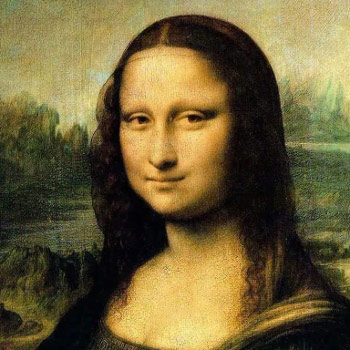

In [155]:
lisa

In [175]:
parameters = {
    'EPOCHS': -1,
    'ELITISM': True,
    'VERBOSE': False,
    'POPULATION_SIZE': 100,
    'DNA_SIZE': 64,
    'MUTATION_CHANCE': 0.30,
    'MUTATION_AMOUNT': 0.30,
    'RANDOM_INHERITANCE': True,
    'SELECTION_CUTOFF': 0.4,
    'NEW_COMERS': 0.40,
    'TARGET': lisa,
    'FUNCTION': 'MSE',
    'IMAGE_MODE': 'RGBA'
}

In [176]:
ev = Evolution(parameters)

In [177]:
ev.start()

Epoch: 50                 | Elapsed time: 25.53 s                 | Size: 100                 | Best: 0.21303052923130036
Epoch: 100                 | Elapsed time: 51.53 s                 | Size: 100                 | Best: 0.21303052923130036
Epoch: 150                 | Elapsed time: 77.54 s                 | Size: 100                 | Best: 0.21187544922282636
Epoch: 200                 | Elapsed time: 103.2 s                 | Size: 100                 | Best: 0.21187544922282636
Epoch: 250                 | Elapsed time: 129.29 s                 | Size: 100                 | Best: 0.19607265990317696
Epoch: 300                 | Elapsed time: 155.49 s                 | Size: 100                 | Best: 0.1753925157200135
Epoch: 350                 | Elapsed time: 182.23 s                 | Size: 100                 | Best: 0.1753925157200135
Epoch: 400                 | Elapsed time: 209.34 s                 | Size: 100                 | Best: 0.1753925157200135
Epoch: 450      

KeyboardInterrupt: 

0.16265336628769156


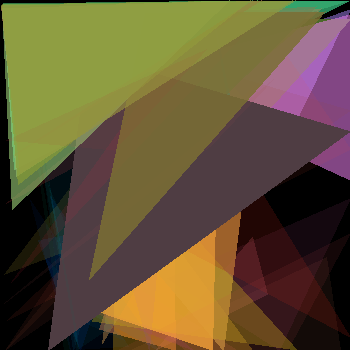

In [179]:
print(ev.alltime_best.fitness)
ev.alltime_best.canvas

In [95]:
canvases = [c.canvas for c in ev.generation_best]

In [96]:
im = Image.new(mode='RGB', size=lisa.size)
im.save('img/evolution.gif', save_all=True, append_images=canvases)